In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
files = ['results_roshambo_STL-S.csv', 'results_roshambo_STL-V.csv', 'results_roshambo_rate.csv', "results_roshambo_latency.csv"]

data = []
for f in files:
    data.append(pd.read_csv('../results/roshambo/' + f))


sparsities 0.08633805555555553 (-0.03761069485511817, 0.21028680596622923)
accuracies 46.67 (32.32, 61.01)

sparsities 0.054898472222222196 (0.025700213473862, 0.08409673097058239)
accuracies 55.56 (47.91, 63.20)

sparsities 0.18405124999999997 (0.12765378903494518, 0.24044871096505477)
accuracies 45.33 (19.52, 71.15)

sparsities 0.20000000000000004 (0.19999999999999996, 0.20000000000000012)
accuracies 35.11 (31.29, 38.94)



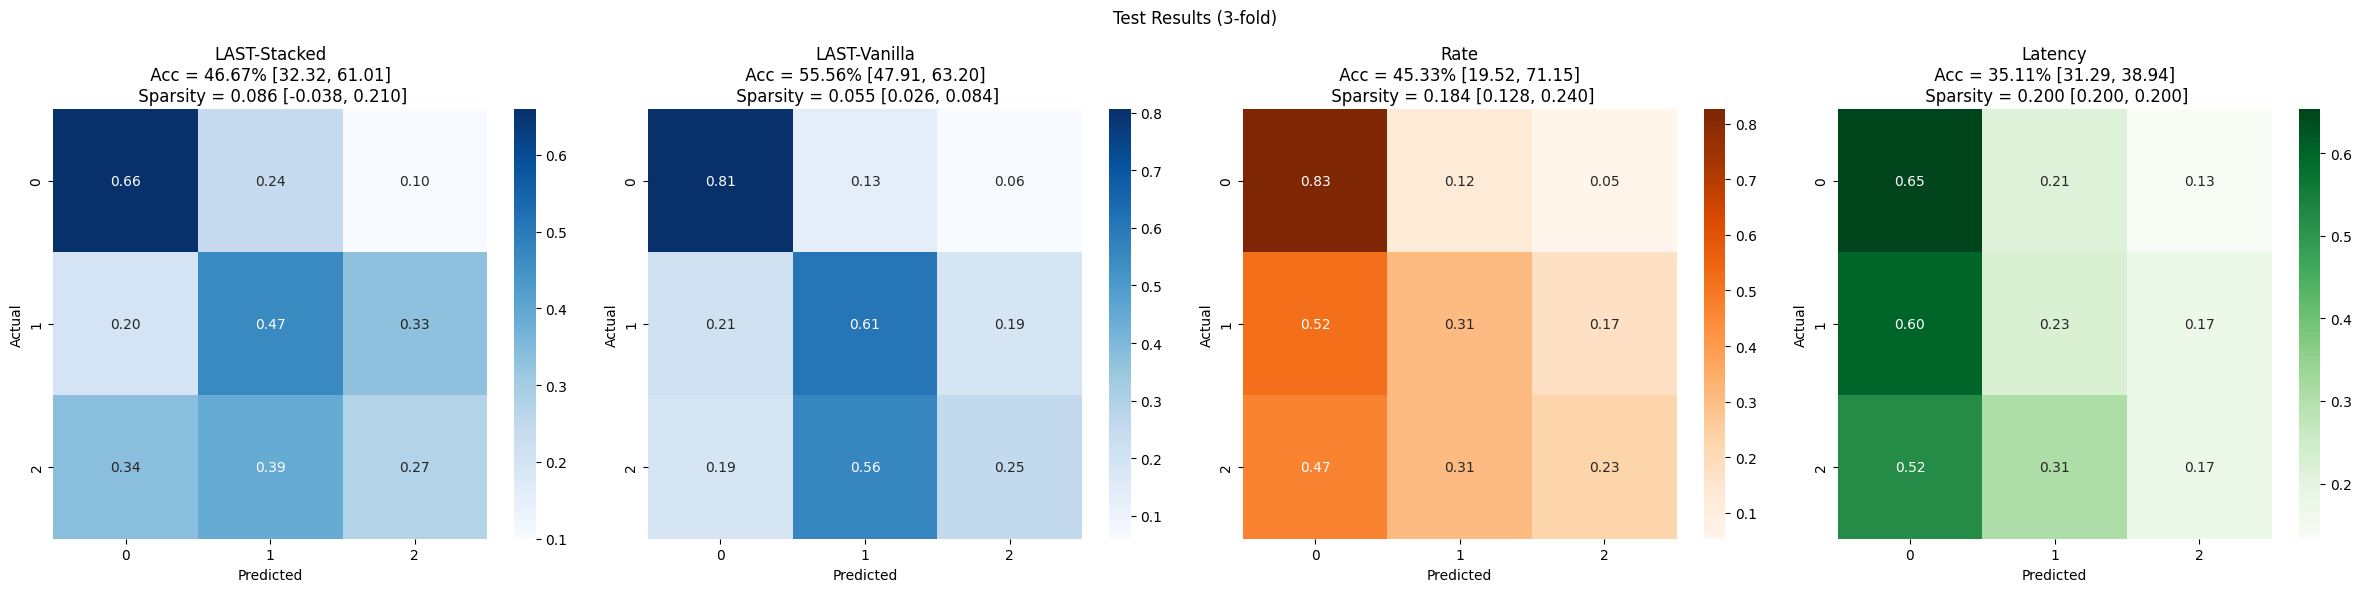

In [24]:
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
import scipy.stats as st
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def parse_string_to_list(input_string):
    # Remove the square brackets and any extra spaces around the string
    input_string = input_string.strip("[]").replace("\n", " ")
    # Split the string by spaces and convert each element to an integer
    try:
        ans = list(map(int, input_string.split(", ")))
    except:
        ans = list(map(float, input_string.split(", ")))
    return ans

def ci(a):
    a = np.array(a)
    ci = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    if ci[0] == np.nan:
        return (a.mean(), a.mean())
    else:
        return ci

fig, ax = plt.subplots(1, len(data), figsize=(6*len(data), 6))
for i, d in enumerate(data):
    f = files[i].split('.')[0]
    if "rate" in files[i]:
        r = "Rate"
        f = f.split('_')[1] + " rate"
        c = "Oranges"
        column = 2
    elif "latency" in files[i]:
        r = "Latency"
        f = f.split('_')[1] + " latency"
        c = "Greens"
        column = 3
    elif "STL-S" in files[i]:
        r = "LAST-Stacked"
        f = f.split('_')[1] + " LAST-S"
        c = "Blues"
        column = 0
    elif "STL-V" in files[i]:
        r = "LAST-Vanilla"
        f = f.split('_')[1] + " LAST-V"
        c = "Blues"
        column = 1
    
    
    test_labels = []
    test_preds = []
    cms = []
    acc = []
    sparsities = []
    aucs = []
    f1s = []
    for fold in range(3):
        test_labels.append(parse_string_to_list(d["test_labels"].values[-fold]))
        test_preds.append(parse_string_to_list(d["test_preds"].values[-fold]))

        acc.append(accuracy_score(test_labels[-fold], test_preds[-fold]))
    
        cms.append(confusion_matrix(test_labels[-fold], test_preds[-fold], normalize='true'))
        sparsities.append(d["sparsity"].values[-fold])
        
        num_classes = np.max(test_labels) + 1
        test_labels_one_hot = np.eye(num_classes)[test_labels]
        test_preds_one_hot = np.eye(num_classes)[test_preds]
        # auc_macro = roc_auc_score(test_labels_one_hot, test_preds_one_hot, multi_class='ovr', average='macro')
        # aucs.append(auc_macro)
        
        f1 = f1_score(test_labels[-fold], test_preds[-fold], average="macro")
        f1s.append(f1)
        
    cms = np.array(cms)
    acc = np.array(acc)
    sparsities = np.array(sparsities)
    
    print("sparsities", sparsities.mean(), ci(sparsities))
    print(f"accuracies {acc.mean()*100:.2f} ({ci(acc)[0]*100:.2f}, {ci(acc)[1]*100:.2f})")
    conf = ci(acc)

    sns.heatmap(cms.mean(axis=0), annot=True, cmap=c, fmt='.2f', ax=ax[column])
    ax[column].set_title(f"{r}\n Acc = {acc.mean()*100:.2f}% [{conf[0]*100:.2f}, {conf[1]*100:.2f}] \n Sparsity = {sparsities.mean():.3f} [{ci(sparsities)[0]:.3f}, {ci(sparsities)[1]:.3f}]")
    ax[column].set_xlabel('Predicted')
    ax[column].set_ylabel('Actual')
    
    # Compute AUC for each class and for micro and macro averages
    test_labels_flat = np.concatenate(test_labels)
    test_preds_flat = np.concatenate(test_preds)

    print()

plt.suptitle("Test Results (3-fold)")
plt.tight_layout()
plt.show()


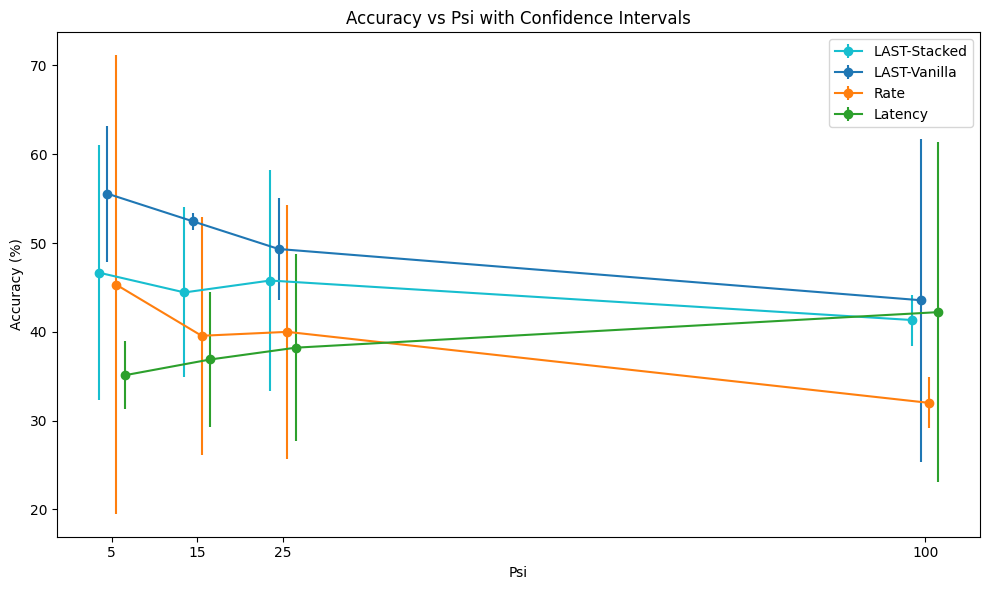

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data
psi_values = np.array([5, 15, 25, 100])
last_stacked_mean = [46.67, 44.44, 45.78, 41.33]
last_stacked_ci = [(32.32, 61.01), (34.88, 54.01), (33.35, 58.21), (38.46, 44.20)]
last_vanilla_mean = [55.56, 52.44, 49.33, 43.56]
last_vanilla_ci = [(47.91, 63.20), (51.49, 53.40), (43.60, 55.07), (25.39, 61.71)]
rate_mean = [45.33, 39.56, 40.00, 32.00]
rate_ci = [(19.52, 71.15), (26.17, 52.94), (25.66, 54.34), (29.13, 34.87)]
latency_mean = [35.11, 36.89, 38.22, 42.22]
latency_ci = [(31.29, 38.94), (29.24, 44.54), (27.70, 48.74), (23.10, 61.35)]

# Calculate error bars
last_stacked_err = [((ci[1] - ci[0]) / 2) for ci in last_stacked_ci]
last_vanilla_err = [((ci[1] - ci[0]) / 2) for ci in last_vanilla_ci]
rate_err = [((ci[1] - ci[0]) / 2) for ci in rate_ci]
latency_err = [((ci[1] - ci[0]) / 2) for ci in latency_ci]

# Shifts for each line
shift = 1.0
psi_stacked = psi_values - shift * 1.5
psi_vanilla = psi_values - shift * 0.5
psi_rate = psi_values + shift * 0.5
psi_latency = psi_values + shift * 1.5

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(psi_stacked, last_stacked_mean, yerr=last_stacked_err, fmt='o-', color='tab:cyan', label='LAST-Stacked')
plt.errorbar(psi_vanilla, last_vanilla_mean, yerr=last_vanilla_err, fmt='o-', color='tab:blue', label='LAST-Vanilla')
plt.errorbar(psi_rate, rate_mean, yerr=rate_err, fmt='o-', color='tab:orange', label='Rate')
plt.errorbar(psi_latency, latency_mean, yerr=latency_err, fmt='o-', color='tab:green', label='Latency')

# Labels and title
plt.xlabel('Psi')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Psi with Confidence Intervals')
plt.xticks(psi_values, labels=list(psi_values))
plt.legend()

# Show plot
# plt.grid(True)
plt.tight_layout()
plt.show()
